In [1]:
from hamming import hamming_allvall, read_fa, write_fa
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

## 1. Create a multiple sequence alignment

If your sequences are already aligned, skip to section 2. <br>
Here we use MAFFT to perform the multiple sequence alignment - so this step requires you install MAFFT.

In [3]:
# input:  fasta-formatted sequences
# output: dataframe, seqs as column name 'seq', header as column name 'header'
seqs_to_align = read_fa('./compare.fasta')

In [4]:
!mkdir mafft_alignment
write_fa(
    seqs_to_align,
    './alignments/myseqs.fa'
)

In [5]:
!mafft ./alignments/myseqs.fa > ./alignments/myseqs.a2m

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8176 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 2101 / 2131
done.

Constructing a UPGMA tree (efffree=0) ... 
 2120 / 2131
done.

Progressive alignment 1/2... 
STEP  1801 / 2130 
Reallocating..done. *alloclen = 1940
STEP  2101 / 2130 
done.

Making a distance matrix from msa.. 
 2100 / 2131
done.

Constructing a UPGMA tree (efffree=1) ... 
 2120 / 2131
done.

Progressive alignment 2/2... 
STEP  2001 / 2130 
Reallocating..done. *alloclen = 1938
STEP  2101 / 2130 
done.

disttbfast (aa) Version 7.520
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It

In [2]:
aln = read_fa('./alignments/myseqs.a2m')

## 2. Compute all-v-all hamming distance matrix

```hamming_allvall``` requires a multiple sequence alignment, in order to rapidly calculate mismatches by avoiding all-vs-all pairwise alignments. <br>
This makes it possible to efficiently compute all-vs-all distances for 100,000s of sequences.

Alternatively, you can compute a distance matrix by all-vs-all pairwise alignments (code not provided).

In [ ]:
# if providing a multiple sequence alignment, and skipping step 2, specify your alignment file here:
# aln = read_fa(MY_MSA_FASTA)

In [3]:
X = hamming_allvall(aln.rename(columns={'seq':'aln'}))

completed: 0 out of 2131 sequences
completed: 200 out of 2131 sequences
completed: 400 out of 2131 sequences
completed: 600 out of 2131 sequences
completed: 800 out of 2131 sequences
completed: 1000 out of 2131 sequences
completed: 1200 out of 2131 sequences
completed: 1400 out of 2131 sequences
completed: 1600 out of 2131 sequences
completed: 1800 out of 2131 sequences
completed: 2000 out of 2131 sequences


## 3. Embed in 2D via MDS

For a given set of D datapoints of M-dimensions, MDS yields a set of D embedded points in N-dimensions <br>
 s.t. distances between embedded points preserve the distances between the original datapoints.

 Commonly, the distance is defined as Euclidean distance. <br>
 Here, we define hamming distance as the datapoint distance, and Euclidean distance as the embedding distance. <br>
 Therefore, our 2-D embedding gives Euclidean distances between points that approximate the hamming distance between the corresponding sequences.

 We take advantage of an existing MDS algorithm that finds the embedding points, and simply provide the hamming distances as a pre-computed DxD matrix.

Note 1: MDS does not find a perfect match of 2-D distance to provided distance. However, for a well-specified hamming matrix, it is typically accurate enough to serve for qualitative interpretation and for rule-of-thumb comparisons.

Note 2: The MDS algorithm will return slightly different solutions unless a random seed is specified. <br>
The biggest difference is typically the global rotation.

In [4]:
embedding = MDS(n_components=2, normalized_stress='auto',dissimilarity = 'precomputed')
X_transformed = embedding.fit_transform(X)

In [5]:
from hamming import hamming
aln['h_wt'] = aln['seq'].apply(lambda x:hamming(x, aln['seq'].iloc[902]))

## 4. Visualize

Here, we illustrate the relationship between distance in sequence space (rainbow color spectrum), and in the 2-D space.

/Users/nathan/miniconda3/envs/torch/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-0.6886878385368077, 0.6764448346885086)

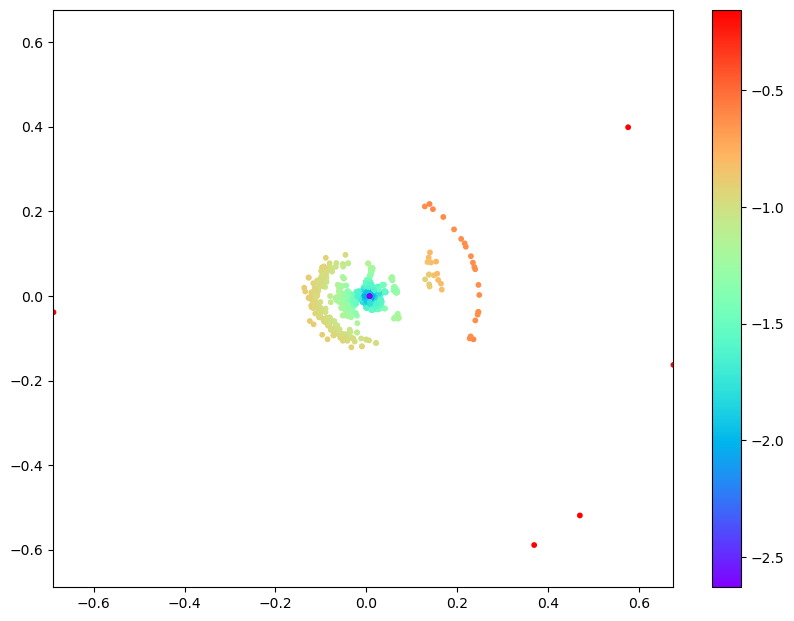

In [14]:
%matplotlib inline
import numpy as np
f,ax = plt.subplots(figsize=(10,7.5))
cm = plt.scatter(X_transformed[:,0],X_transformed[:,1], c=np.log10(aln['h_wt']),
           cmap='rainbow', s=10)
plt.colorbar(cm)
plt.gca().set_xlim(X_transformed.min(),X_transformed.max())
plt.gca().set_ylim(X_transformed.min(),X_transformed.max())

## 5. Compare how well the MDS 2-D distances agree with all-vs-all hamming distances.

In [ ]:
# compute euclidean distances between points
D = np.sqrt(np.sum((X_transformed[:,np.newaxis,:] - X_transformed[np.newaxis,:,:])**2, axis=-1))

Text(0, 0.5, '2-D distance')

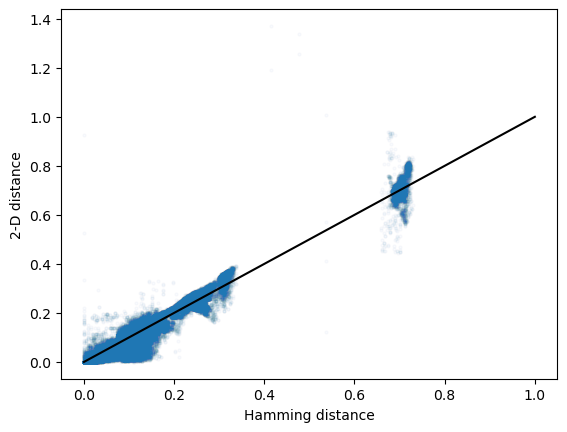

In [23]:
a = X.flatten()
b = D.flatten()

f, ax = plt.subplots()
ax.scatter(a,b, alpha=0.01,s=5)
ax.plot([0,1],[0,1],c='k')
ax.set_xlabel('Hamming distance')
ax.set_ylabel('2-D distance')
